## Notebook Content:
1. Imports.
2. Loading the Dataset.
3. Data Analyis.
4. Data Pre-processing and Visualization.
5. Creating the Train, Validation and Test Sets.
6. Creating the Model.
7. Training the Model.
8. Plotting.
9. Evaluation.
10. Saving the Model.

In [1]:
%load_ext autoreload
%autoreload 2


# 1. Imports

In [2]:
# PyTorch imports:
import torch
import torchvision.transforms as T

# Model imports:
from model.model import DigitRecognizerModel

# Dataset imports:
from dataset.dataset import DigitDataset

# Custom transforms imports:
from utils.custom_transforms import Sharpen, Contrast

# Train and Evaluation imports:
from utils.train_eval import train, evaluate

# Sklearn imports:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# NumPy imports:
import numpy as np

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Other imports:
from pathlib import Path
import yaml
import os
import random
import math


In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


# 2. Loading the Dataset:

### a. Creating the dataset:

In [4]:
dataset = DigitDataset()


# 3. Data Analysis

### a. Number of images in the dataset:

In [5]:
dataset_size = len(dataset)
print(f'The dataset contains: {dataset_size} images')


The dataset contains: 42000 images


### b. Number of images in each class:

<BarContainer object of 10 artists>

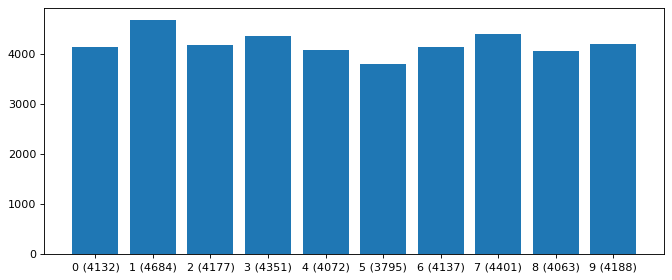

In [6]:
figure(figsize=(10, 4), dpi=80)

# Calculating the class distribution:
class_distribution = np.bincount(dataset.labels)
class_distribution = dict(zip(np.unique(dataset.labels), class_distribution))

x = [f'{key} ({val})' for key, val in class_distribution.items()]

plt.bar(x, class_distribution.values())


# 4. Data Pre-processing and Visualization:

### a. Loading the mean and standard deviation calculated that are located in the data/data_stats.yaml
The mean and standard deviation will be used when normalizing the dataset.

In [7]:
dataset_stats_path = Path().resolve() / "dataset" / "dataset_stats.yaml"

with open(dataset_stats_path, 'r') as file:
    dataset_stats = yaml.safe_load(file)
mean, std = dataset_stats["mean"][0], dataset_stats["std"][0],

print(f"Mean: {mean:.4f}\nStandard Deviation: {std:.4f}")


Mean: 0.1310
Standard Deviation: 0.3085


### b. Creating the pre-processing criteria which consists of the follwing:
1. Converting the images to PyTorch tensors.
2. Normalizing the images with the mean and standard deviation of the dataset.

In [8]:
# sharpness_factor = 6.0
# sharpen = Sharpen(sharpness_factor=sharpness_factor)

# contrast_factor = 5.5
# contrast = Contrast(contrast_factor=contrast_factor)

transforms = [T.ToTensor(), T.Normalize(mean=mean, std=std), T.Resize((128, 128))]
dataset_transform = T.Compose(transforms)


### c. Creating a dataset with pre-processing:

In [9]:
preprocessed_dataset = DigitDataset(transforms=dataset_transform)


### d. Visualizing the difference between the preprocessed and original datasets:

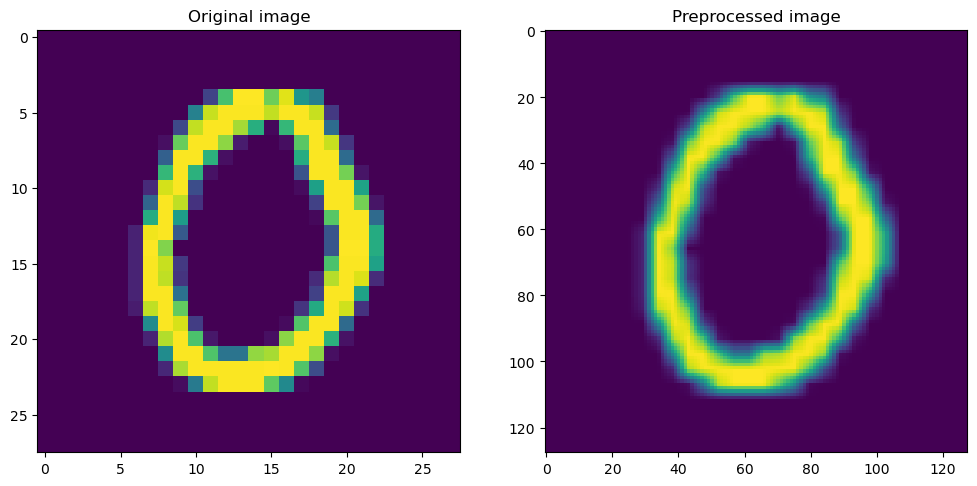

In [10]:
# Getting an image with the same index from both the original and pre-processed datasets:
index = random.randint(0, len(dataset))

original_image, label = dataset[index]
preprocessed_image, label = preprocessed_dataset[index]
preprocessed_image = np.transpose(preprocessed_image.cpu().detach().numpy(), (1, 2, 0))

# Creating the plot:
fig, axarr = plt.subplots(1, 2)

# Setting the figure size:
fig_width, fig_height = 12, 6

fig.set_figwidth(fig_width)
fig.set_figheight(fig_height)

# -- Plotting the images: ----
# The original image:
axarr[0].set_title(f'Original image')
axarr[0].imshow(original_image)
# The pre-processed image:
axarr[1].set_title(f'Preprocessed image')
axarr[1].imshow(preprocessed_image)


# 5. Creating the Train, Validation and Test Sets:

### a. Creating the pre-processing criteria for all the splits:

In [11]:
# # Configuring the Sharpen transform:
# sharpness_factor = 2.0
# sharpen = Sharpen(sharpness_factor=sharpness_factor)

# # Configuring the Constrast transform:
# contrast_factor = 2.0
# contrast = Contrast(contrast_factor=contrast_factor)

# Defining the transforms that are shared between all the splits:
# shared_transform = [T.ToTensor(), T.Normalize(mean=mean, std=std), sharpen, contrast, T.Resize((128, 128))]
shared_transform = [T.ToTensor(), T.Normalize(mean=mean, std=std), T.Resize((64, 64))]


In [12]:
# Defining the proportion of each split:
train_proportion, val_proportion = 0.8, 0.2

# Defining the size of each split:
train_size = math.floor(len(dataset) * train_proportion)
val_size = math.ceil(len(dataset) * val_proportion)

np.random.seed(100)

indecies = np.arange(len(dataset))
np.random.shuffle(indecies)

# Creating the indecies of each data split:
train_indecies = indecies[0:train_size]
val_indecies = indecies[train_size: train_size + val_size]

# Creating two different datasets the first one with the train transform
# and the other one with the validation and test transform.
train_set = DigitDataset(transforms=shared_transform)

# Defining the data splits as Subsets of the original datasets defined above.
# This method makes sure that the train transform is applied to the train
# split and the same for the other splits.
train_set = torch.utils.data.Subset(train_set, train_indecies)
val_set = torch.utils.data.Subset(train_set, val_indecies)
test_set = DigitDataset(transforms=shared_transform, train=False)

print(f'Train set size: {train_size}\nValidation set size: {val_size}\nTest set size: {len(test_set)}')


Train set size: 33600
Validation set size: 8400
Test set size: 28000


### c. Creating the Data Loaders for all the splits:

In [13]:
# Defining the parameters that are the same for all of the data loaders:
data_loader_params = {'batch_size' : 64, 'num_workers' : 8, 'pin_memory' : True}

# Defining the data loaders:
train_loader = torch.utils.data.DataLoader(dataset=train_set, shuffle=True, **data_loader_params)
val_loader = torch.utils.data.DataLoader(dataset=val_set, shuffle=True, **data_loader_params)
test_loader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, **data_loader_params)


# 6. Creating the Model

In [14]:
model = DigitRecognizerModel()
model


DigitRecognizerModel(
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_1): Dropout(p=0.25, inplace=False)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_2): Dropout(p=0.35, inplace=False)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_3): Dropout(p=0.5, inplace=Fa

# 7. Training the Model:

### a. Setting up the training routine:

In [15]:
# -- The Optimizer: ----
optimizer_params = {'params' : model.parameters(), 'lr' : 1e-3, 'weight_decay' : 0}
optimizer = torch.optim.AdamW(**optimizer_params)

# -- The Loss Function: ----
criterion = torch.nn.CrossEntropyLoss()

# -- The Learning Rate Scheduler: ----
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 30], gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.075, total_iters=40)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# -- Number of Epochs: ----
epochs = 20


In [16]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params


64490

In [17]:
# Setting the training parameters:
train_params = {'model' : model, 'optimizer' : optimizer, 'criterion' : criterion, 'train_loader' : train_loader,
                'val_loader' : val_loader, 'epochs' : epochs, 'lr_scheduler' : lr_scheduler, 'verbose' : True}

train_loss, val_loss, train_accuracies, val_accuracies, lrs = train(**train_params)


RuntimeError: "host_softmax" not implemented for 'Long'